<a href="https://colab.research.google.com/github/Priyankaverma2024/Capstone-Project-1/blob/main/ROSSMANN_STORE_SALES_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# mounted My Google Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# load zip file dataset to extract all kind of datasets
import zipfile
import os

# Define the path to the uploaded file
uploaded_file_path = '/content/drive/MyDrive/rossmann-store-sales.zip'
extracted_folder_path = '/content/drive/MyDrive/rossmann-store-sales'

# Extract the contents of the zip file
with zipfile.ZipFile(uploaded_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# List the extracted files to understand the structure
os.listdir(extracted_folder_path)

['sample_submission.csv', 'store.csv', 'test.csv', 'train.csv']

The extracted files from the dataset are:

train.csv: Likely contains the training data for model building.
test.csv: Likely contains the test data for predictions.
store.csv: Possibly contains additional metadata about the stores.
sample_submission.csv: May provide a template for submission or expected output format.

In [ ]:
# Read given datsets to observe them

# Load the training data
train_file_path = os.path.join(extracted_folder_path, 'train.csv')
train_data = pd.read_csv(train_file_path)

# Display basic information and the first few rows of the training data
train_data.info(), train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


(None,
    Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
 0      1          5  2015-07-31   5263        555     1      1            0   
 1      2          5  2015-07-31   6064        625     1      1            0   
 2      3          5  2015-07-31   8314        821     1      1            0   
 3      4          5  2015-07-31  13995       1498     1      1            0   
 4      5          5  2015-07-31   4822        559     1      1            0   
 
    SchoolHoliday  
 0              1  
 1              1  
 2              1  
 3              1  
 4              1  )

In [ ]:
train_data.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


The train.csv dataset contains 1,017,209 entries with the following columns:

Store: Identifier for the store.
DayOfWeek: Day of the week (1=Monday, 7=Sunday).
Date: Date of the entry.
Sales: Sales for that store on the given day (target variable).
Customers: Number of customers visiting the store.
Open: Whether the store was open (1) or closed (0).
Promo: Whether a promotion was active (1) or not (0).
StateHoliday: Whether the day was a state holiday (0 = None, 'a', 'b', 'c').
SchoolHoliday: Whether it was a school holiday (1 or 0).

Some observations:

Date is a string and should be converted to a datetime format.

StateHoliday has mixed types (likely categorical data).

Next, we will preview the test.csv file to understand its structure and ensure alignment with the training data.

In [ ]:
# Load the test data
test_file_path = os.path.join(extracted_folder_path, 'test.csv')
test_data = pd.read_csv(test_file_path)

# Display basic information and the first few rows of the test data
test_data.info(), test_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


(None,
    Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
 0   1      1          4  2015-09-17   1.0      1            0              0
 1   2      3          4  2015-09-17   1.0      1            0              0
 2   3      7          4  2015-09-17   1.0      1            0              0
 3   4      8          4  2015-09-17   1.0      1            0              0
 4   5      9          4  2015-09-17   1.0      1            0              0)

The test.csv dataset contains 41,088 entries with the following columns:

Id: Unique identifier for each entry (likely for submission).

Store: Store identifier.

DayOfWeek: Day of the week (1=Monday, 7=Sunday).

Date: Date of the entry.

Open: Whether the store was open (1), closed (0), or missing.

Promo: Whether a promotion was active (1 or 0).

StateHoliday: Whether the day was a state holiday.

SchoolHoliday: Whether it was a school holiday (1 or 0).


Key observations:

The target variable (Sales) is missing in this dataset, as it is the one to predict.
The Open column has some missing values.

To proceed, we will:

Join additional store information (from store.csv).
Preprocess both datasets (e.g., handle dates, encode categorical variables, and fill missing values).
Build and evaluate a predictive model for Sales

In [ ]:
# Load the store information data
store_file_path = os.path.join(extracted_folder_path, 'store.csv')
store_data = pd.read_csv(store_file_path)

# Display basic information and the first few rows of the store data
store_data.info(), store_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


(None,
    Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
 0      1         c          a               1270.0                        9.0   
 1      2         a          a                570.0                       11.0   
 2      3         a          a              14130.0                       12.0   
 3      4         c          c                620.0                        9.0   
 4      5         a          a              29910.0                        4.0   
 
    CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
 0                    2008.0       0              NaN              NaN   
 1                    2007.0       1             13.0           2010.0   
 2                    2006.0       1             14.0           2011.0   
 3                    2009.0       0              NaN              NaN   
 4                    2015.0       0              NaN              NaN   
 
      PromoInterval  
 0              NaN  
 1  Jan,A

In [ ]:
# Load the submission file information
sample_submission_file_path = os.path.join(extracted_folder_path, 'sample_submission.csv')
sample_submission = pd.read_csv(sample_submission_file_path)

#Display basic information and the first few rows of the submission file
sample_submission.info(), sample_submission.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Id      41088 non-null  int64
 1   Sales   41088 non-null  int64
dtypes: int64(2)
memory usage: 642.1 KB


(None,
    Id  Sales
 0   1      0
 1   2      0
 2   3      0
 3   4      0
 4   5      0)

# Merge Store Data
 Merge store.csv with both train and test datasets:

In [ ]:

train = train_data.merge(store_data, on='Store', how='left')
test = test_data.merge(store_data, on='Store', how='left')

For Time Series forecasting we need to feed our both datasets with saimilar feauers like lag and rolling for futuer sales predictions using the following steps:

1  sort our data by store and Date.

2  Add a place holder for sales in test dataset .

3 combine both datasets and create combine dataset for feeding them by lag and rolling featuers .

4 Now again split back into train and test dataset as it is.


In [ ]:
# sort by  Store and Date
train = train_data.sort_values(['Store', 'Date'])
test = test_data.sort_values(['Store', 'Date'])

In [ ]:
# Add a placeholder 'Sales' column in test_data
test['Sales'] = None


In [ ]:
# Combine train and test data
combined_data = pd.concat([train, test], sort=False)


In [ ]:
# Add lag features (past sales for the last 6 weeks)
for lag in range(1, 7):  # Lag for 1 to 6 weeks
    combined_data[f'Lag_{lag}'] = combined_data.groupby('Store')['Sales'].shift(lag * 7)

# Add rolling features (mean and sum over the last 6 weeks)
combined_data['Rolling_Mean_6w'] = combined_data.groupby('Store')['Sales'].transform(
    lambda x: x.shift(1).rolling(window=6*7).mean()
)
combined_data['Rolling_Sum_6w'] = combined_data.groupby('Store')['Sales'].transform(
    lambda x: x.shift(1).rolling(window=6*7).sum()
)

In [ ]:
# Split back into train and test data
train_data = combined_data[combined_data['Sales'].notna()]
test_data = combined_data[combined_data['Sales'].isna()]


# Preprocess the Data
Convert the Date column to a datetime format:

In [ ]:
# Convert the Date column to a datetime format in both train and test DataFrames:
train_data['Date'] = pd.to_datetime(train['Date'])
test_data['Date'] = pd.to_datetime(test['Date'])

Extract date-related features:

In [ ]:
train_data['Year'] = train_data['Date'].dt.year
train_data['Month'] = train_data['Date'].dt.month
train_data['Day'] = train_data['Date'].dt.day
train_data['WeekOfYear'] = train_data['Date'].dt.isocalendar().week
train_data['DayOfWeek'] = train_data['Date'].dt.dayofweek
train_data['IsHoliday'] = train_data['StateHoliday'].apply(lambda x :1 if x !='0' else 0)



test_data['Year'] = test_data['Date'].dt.year
test_data['Month'] = test_data['Date'].dt.month
test_data['Day'] = test_data['Date'].dt.day
test_data['WeekOfYear'] = test_data['Date'].dt.isocalendar().week
test_data['DayOfWeek'] = test_data['Date'].dt.dayofweek
test_data['IsHoliday'] = test_data['StateHoliday'].apply(lambda x :1 if x !='0' else 0)


In [ ]:
# Handle missing values
train_data.fillna(0, inplace=True)
test_data.fillna(0, inplace=True)


Validate

Recheck missing values to ensure everything is filled:

In [ ]:
train_data.isnull().sum()

,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
Id,0


In [ ]:
test_data.isnull().sum()

,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
Id,0


In [ ]:
# to get information fo data dtype
train_data.info(),test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1017209 entries, 1016095 to 1114
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   Store            1017209 non-null  int64         
 1   DayOfWeek        1017209 non-null  int32         
 2   Date             1017209 non-null  datetime64[ns]
 3   Sales            1017209 non-null  object        
 4   Customers        1017209 non-null  float64       
 5   Open             1017209 non-null  float64       
 6   Promo            1017209 non-null  int64         
 7   StateHoliday     1017209 non-null  object        
 8   SchoolHoliday    1017209 non-null  int64         
 9   Id               1017209 non-null  float64       
 10  Lag_1            1017209 non-null  int64         
 11  Lag_2            1017209 non-null  int64         
 12  Lag_3            1017209 non-null  int64         
 13  Lag_4            1017209 non-null  int64         
 14  Lag_

(None, None)

#  To check and remove Outliers

In [ ]:
# Calculate IQR for Sales
Q1 = train_data['Sales'].quantile(0.25)
Q3 = train_data['Sales'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = train_data[(train_data['Sales'] < Q1 - 1.5 * IQR) | (train_data['Sales'] > Q3 + 1.5 * IQR)]
print(f"Number of Sales outliers: {len(outliers)}")

Number of Sales outliers: 26694


 Handle Outliers
Options to handle outliers:

Clip Values: Limit extreme values to a threshold.

In [ ]:
train_data['Sales'] = np.clip(train_data['Sales'], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

Remove Outliers:

In [ ]:
train_data = train_data[~((train_data['Sales'] < Q1 - 1.5 * IQR) | (train_data['Sales'] > Q3 + 1.5 * IQR))]

In [ ]:
# Calculate IQR for  verifying  Sales  outliers are removed or not
Q1 = train_data['Sales'].quantile(0.25)
Q3 = train_data['Sales'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = train_data[(train_data['Sales'] < Q1 - 1.5 * IQR) | (train_data['Sales'] > Q3 + 1.5 * IQR)]
print(f"Number of Sales outliers: {len(outliers)}")

Number of Sales outliers: 0


In [ ]:
# Calculate IQR for Sales
Q1 = test_data['Sales'].quantile(0.25)
Q3 = test_data['Sales'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = test_data[(test_data['Sales'] < Q1 - 1.5 * IQR) | (test_data['Sales'] > Q3 + 1.5 * IQR)]
print(f"Number of Sales outliers: {len(outliers)}")

Number of Sales outliers: 0


In [ ]:
# Customers
# Calculate IQR for customers
Q1 = train_data['Customers'].quantile(0.25)
Q3 = train_data['Customers'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = train_data[(train['Customers'] < Q1 - 1.5 * IQR) | (train_data['Customers'] > Q3 + 1.5 * IQR)]
print(f"Number of Customers outliers: {len(outliers)}")

Number of Customers outliers: 38095


In [ ]:
train_data['Customers'] = np.clip(train_data['Customers'], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
# Outliers removed

train_data = train_data[~((train_data['Customers'] < Q1 - 1.5 * IQR) | (train_data['Customers'] > Q3 + 1.5 * IQR))]

In [ ]:
# Calculate IQR for customers outliers are removed  verify
Q1 = train_data['Customers'].quantile(0.25)
Q3 = train_data['Customers'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = train_data[(train_data['Customers'] < Q1 - 1.5 * IQR) | (train_data['Customers'] > Q3 + 1.5 * IQR)]
print(f"Number of Customers outliers: {len(outliers)}")

Number of Customers outliers: 0


In [ ]:
# Calculate IQR for customers
Q1 = test_data['Customers'].quantile(0.25)
Q3 = test_data['Customers'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = test_data[(test_data['Customers'] < Q1 - 1.5 * IQR) | (test_data['Customers'] > Q3 + 1.5 * IQR)]
print(f"Number of Customers outliers: {len(outliers)}")

Number of Customers outliers: 0


In [ ]:
# Calculate IQR for Store
Q1 = train_data['Store'].quantile(0.25)
Q3 = train_data['Store'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = train_data[(train_data['Store'] < Q1 - 1.5 * IQR) | (train_data['Store'] > Q3 + 1.5 * IQR)]
print(f"Number of Store outliers: {len(outliers)}")

Number of Store outliers: 0


In [ ]:
# Calculate IQR for Store
Q1 = test_data['Store'].quantile(0.25)
Q3 = test_data['Store'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = test_data[(test_data['Store'] < Q1 - 1.5 * IQR) | (test_data['Store'] > Q3 + 1.5 * IQR)]
print(f"Number of Store outliers: {len(outliers)}")

Number of Store outliers: 0


In [ ]:
# Calculate IQR for promo in train data
Q1 = train_data['Promo'].quantile(0.25)
Q3 = train_data['Promo'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = train_data[(train_data['Promo'] < Q1 - 1.5 * IQR) | (train_data['Promo'] > Q3 + 1.5 * IQR)]
print(f"Number of promo outliers: {len(outliers)}")

Number of promo outliers: 0


In [ ]:
# Calculate IQR for promo in test_data
Q1 = test_data['Promo'].quantile(0.25)
Q3 = test_data['Promo'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = test_data[(test_data['Promo'] < Q1 - 1.5 * IQR) | (test_data['Promo'] > Q3 + 1.5 * IQR)]
print(f"Number of Store outliers: {len(outliers)}")

Number of Store outliers: 0


# Exploratory Data Analysis

To get more insights visualize our data

selected  analysis for customer perchase behavior extracted from previous notebook

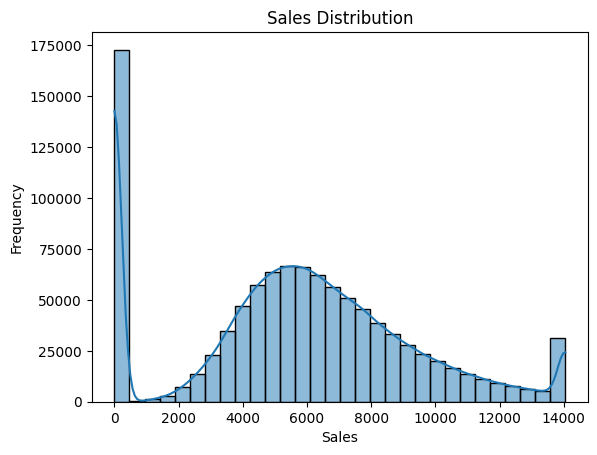

In [ ]:
sns.histplot(train_data['Sales'], kde=True, bins=30)
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

Sales Distribution is showing zero sales when stores are close or end of promos.due to Absence of customers it may possible.

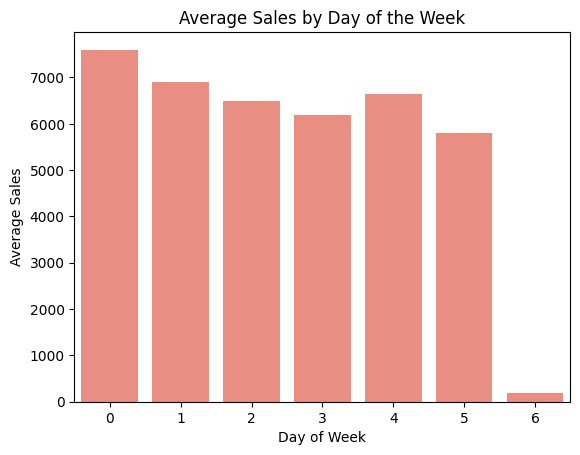

In [ ]:
avg_sales_by_day = train_data.groupby('DayOfWeek')['Sales'].mean()
sns.barplot(x=avg_sales_by_day.index, y=avg_sales_by_day.values,color='salmon')
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.show()

Customers visit stores mostly on Monday(0)stores average sales  will display this but on  Sunday(6) may be due to holiday sales are minmum.

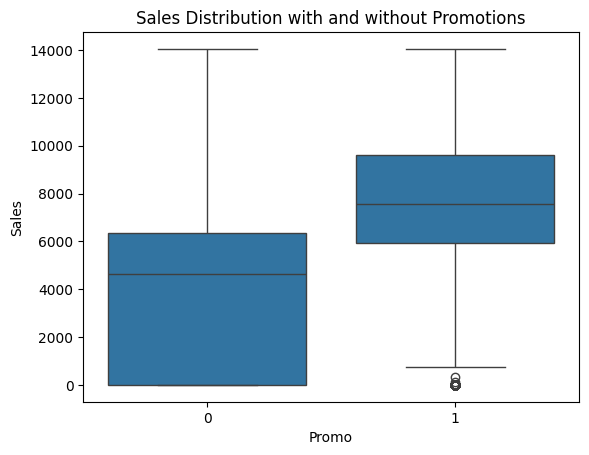

In [ ]:
sns.boxplot(x=train_data['Promo'], y=train_data['Sales'])
plt.title('Sales Distribution with and without Promotions')
plt.xlabel('Promo')
plt.ylabel('Sales')
plt.show()

Insight : without promotions sales goes upto 6000 something  as compare to with promotion sales goes upto  10000 something that means definatly promotions gives more and more apportunity to get higher sales.

Compare the distribution of promotions across training and test sets.

In [ ]:
# Training set promo distribution
train_promo_dist = train_data['Promo'].value_counts(normalize=True) * 100

# Test set promo distribution
test_promo_dist = test_data['Promo'].value_counts(normalize=True) * 100

print("Promo Distribution in Training Set (%):\n", train_promo_dist)
print("\nPromo Distribution in Test Set (%):\n", test_promo_dist)

Promo Distribution in Training Set (%):
 Promo
0    61.848548
1    38.151452
Name: proportion, dtype: float64

Promo Distribution in Test Set (%):
 Promo
0    60.416667
1    39.583333
Name: proportion, dtype: float64


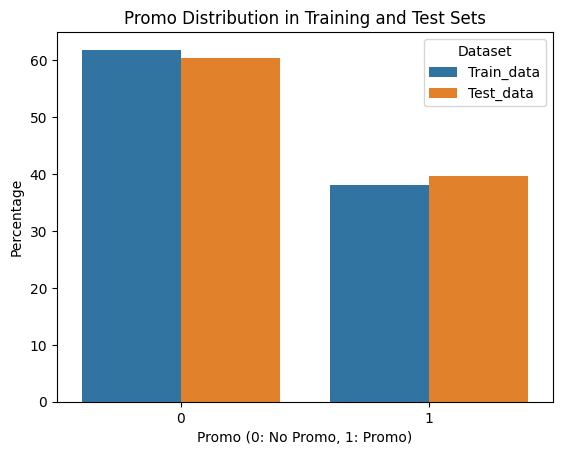

In [ ]:
# Combine promo data for visualization
promo_dist = pd.DataFrame({
    'Dataset': ['Train_data'] * len(train_promo_dist) + ['Test_data'] * len(test_promo_dist),
    'Promo': train_promo_dist.index.tolist() + test_promo_dist.index.tolist(),
    'Percentage': train_promo_dist.tolist() + test_promo_dist.tolist()
})

# Plot
sns.barplot(data=promo_dist, x='Promo', y='Percentage', hue='Dataset')
plt.title('Promo Distribution in Training and Test Sets')
plt.xlabel('Promo (0: No Promo, 1: Promo)')
plt.ylabel('Percentage')
plt.show()

Above barplot is about promo percentage avilable in both training and testing dataset. it's ratio is 61:38 for training and 60:39 for testing data  

Analyze Sales Trends Around Holidays

This involves identifying sales patterns
before, during, and after holidays.

Step 1: Extract Holiday Periods

Use the StateHoliday column in the dataset to identify holiday-related sales.

Step 2: Aggregate Sales by Holiday Period
Summarize average sales by HolidayPeriod:

Step 3: Visualize Trends

Plot the average sales for each period:

In [ ]:
# Convert 'Date' column to datetime if not done yet
#train['Date'] = pd.to_datetime(train['Date'])

# Add a 'HolidayFlag' for analysis
train_data['HolidayFlag'] = train_data['StateHoliday'].apply(lambda x: 1 if x != '0' else 0)

# Identify sales before, during, and after holidays (7-day window)
train_data['HolidayPeriod'] = 'Non-Holiday'
train_data.loc[train_data['HolidayFlag'] == 1, 'HolidayPeriod'] = 'During Holiday'
train_data.loc[(train_data['Date'] + pd.Timedelta(days=7)).isin(train_data.loc[train_data['HolidayFlag'] == 1, 'Date']), 'HolidayPeriod'] = 'Post-Holiday'
train_data.loc[(train_data['Date'] - pd.Timedelta(days=7)).isin(train_data.loc[train_data['HolidayFlag'] == 1, 'Date']), 'HolidayPeriod'] = 'Pre-Holiday'

In [ ]:
holiday_sales = train_data.groupby('HolidayPeriod')['Sales'].mean()
print(holiday_sales)

HolidayPeriod
During Holiday     250.755764
Non-Holiday       5771.691844
Post-Holiday      6470.224558
Pre-Holiday       5891.658123
Name: Sales, dtype: object


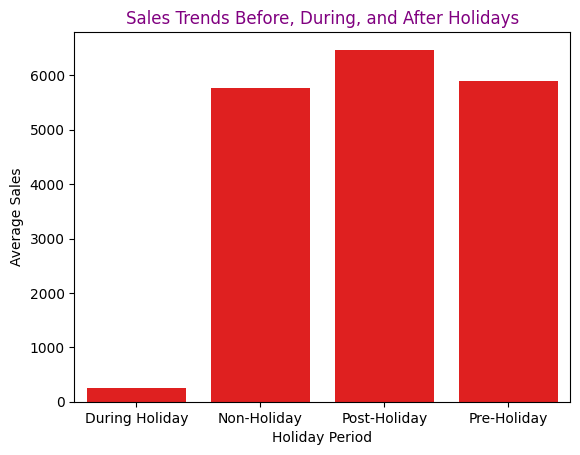

In [ ]:
sns.barplot(x=holiday_sales.index, y=holiday_sales.values,color='red')
plt.title('Sales Trends Before, During, and After Holidays',color='purple')
plt.xlabel('Holiday Period')
plt.ylabel('Average Sales')
plt.show()

Customers sales trend is clearly visible by the above barplot of holiday vs sales mostly pharma related stores sales minimum during the holidays as compare to post Holiday ,non holiday and pre holidays due to out of stations or some other reasons .

# Investigate Seasonal Purchasing Patterns
Focus on specific holidays like Christmas and Easter to uncover trends.

Step 1: Flag Seasonal Events
Manually define key holidays (e.g., Christmas, Easter):

Step 2: Aggregate Sales by Season
Compute total or average sales for each season:
Step 3: Visualize Seasonal Patterns
Create a bar plot for sales by season:

In [ ]:
# Add a 'Season' column
train_data['Season'] = 'Regular'
train_data.loc[(train_data['Date'].dt.month == 12) & (train_data['Date'].dt.day >= 20), 'Season'] = 'Christmas'
train_data.loc[(train_data['Date'].dt.month==11,'Season')] = 'Diwali'   # Adjust for Diwali range as needed
train_data.loc[train_data['Date'].dt.month == 4, 'Season'] = 'Easter'  # Adjust for Easter range as needed

In [ ]:
# Compute total or average sales for each season:
season_sales = train_data.groupby('Season')['Sales'].mean()
print(season_sales)


Season
Christmas    5173.781301
Diwali        5929.98335
Easter       5656.427544
Regular      5692.570245
Name: Sales, dtype: object


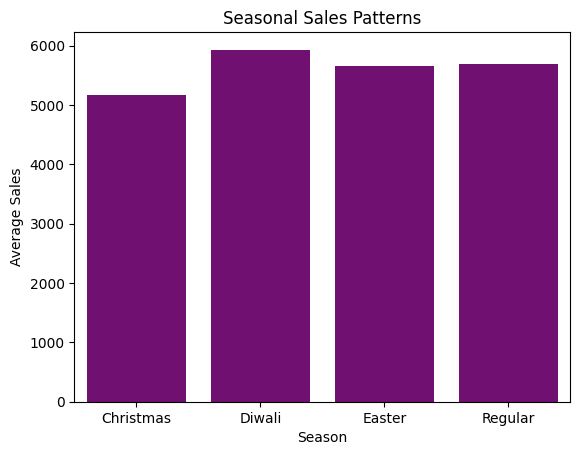

In [ ]:
# Create a bar plot for sales by season:
sns.barplot(x=season_sales.index, y=season_sales.values,color='purple')
plt.title('Seasonal Sales Patterns')
plt.xlabel('Season')
plt.ylabel('Average Sales')
plt.show()


According to above seasonal pattern of average sales maximum visible in november month (Diwali festival period) as well as its peak of winters affect on humans health directly .It is one of the reason for sales hike in these months

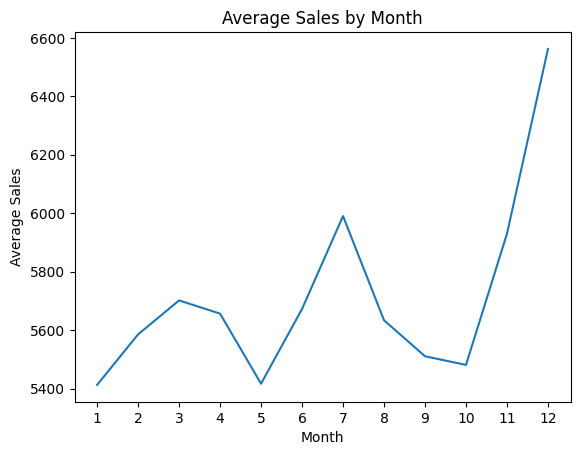

In [ ]:
# monthly trend
# train['Month'] = train['Date'].dt.month
monthly_sales = train_data.groupby('Month')['Sales'].mean()

sns.lineplot(x=monthly_sales.index, y=monthly_sales.values,palette='viridis')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(1, 13))
plt.show()

 first ,fifth and between nine and tenth month sales becomes very low as compare to other months specially elevanth and tweleth month .

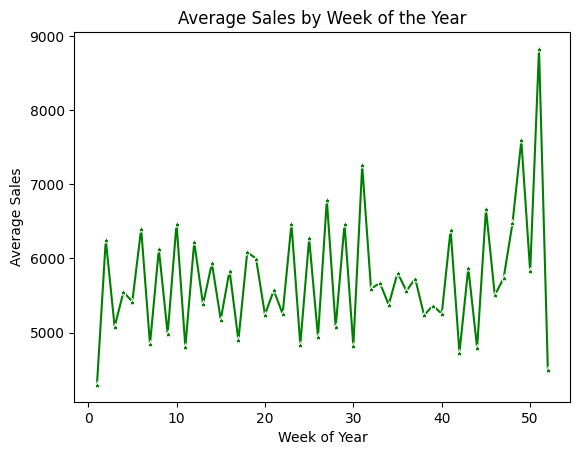

In [ ]:
# weekly trend
weekly_sales = train_data.groupby('WeekOfYear')['Sales'].mean()

sns.lineplot(x=weekly_sales.index, y=weekly_sales.values,color='green',marker='*')
plt.title('Average Sales by Week of the Year')
plt.xlabel('Week of Year')
plt.ylabel('Average Sales')
plt.show()

average sales of weeks during the whole  year is showing similar up and down but end othe year it goes very high due to seasonality.

In [ ]:
sales_by_store = train_data.groupby('Store')['Sales'].sum().sort_values(ascending=False)
print(sales_by_store.head(10))

Store
262     13232859.5
562     13129525.0
733     12920951.5
1114    10993998.5
788     10977983.0
335     10971360.5
513     10952700.5
817     10943902.0
251     10919037.5
383     10886551.0
Name: Sales, dtype: object


In [ ]:
# train['Month'] = train['Date'].dt.month
monthly_sales = train_data.groupby('Month')['Sales'].sum().sort_values(ascending=False)
print(monthly_sales)

Month
3     591222044.5
7     587734878.0
6     569210482.5
4     567622504.0
5     561662600.5
1     561230118.5
2     523111115.5
12    417034292.5
11    364693976.0
8     358021695.0
10    348310836.0
9     338890921.0
Name: Sales, dtype: object




**Trends of Sales Based on Store Opening/Closing Times**

Step 1: Analyze Sales When Stores Are Closed

Separate and summarize sales when stores are open (Open = 1) versus closed (Open = 0).

Step 2: Visualize Sales by Store Status

In [ ]:
# Group sales by store status (open/closed)
open_sales = train_data.groupby('Open')['Sales'].mean()

print(f"Average Sales When Open: {open_sales.get(1, 0)}")
print(f"Average Sales When Closed: {open_sales.get(0, 0)}")

Average Sales When Open: 6855.519076447906
Average Sales When Closed: 0.0


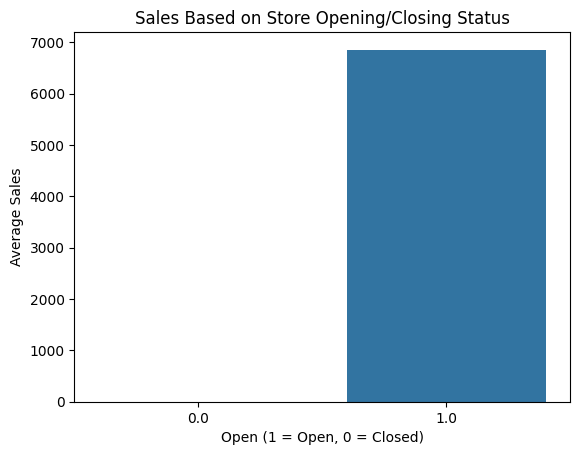

In [ ]:
#  visualize sales by store status

sns.barplot(x=open_sales.index, y=open_sales.values)
plt.title('Sales Based on Store Opening/Closing Status')
plt.xlabel('Open (1 = Open, 0 = Closed)')
plt.ylabel('Average Sales')
plt.show()

**Correlation Between Sales and Customer Numbers**

Step 1: Calculate Correlation

Use Pearson's correlation to assess the relationship between sales and customer numbers:

In [ ]:
correlation = train_data[['Sales', 'Customers']].corr().iloc[0, 1]
print(f"Correlation between Sales and Customer Numbers: {correlation}")

Correlation between Sales and Customer Numbers: 0.9208048531996862


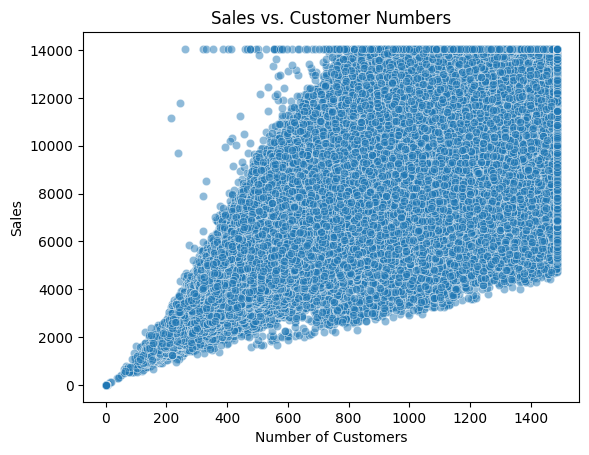

In [ ]:
# Visualize the Relationship
# Create a scatter plot to show the relationship:

sns.scatterplot(x='Customers', y='Sales', data=train_data, alpha=0.5,palette='viridis')
plt.title('Sales vs. Customer Numbers')
plt.xlabel('Number of Customers')
plt.ylabel('Sales')
plt.show()

Insights to Look For:
A strong positive correlation indicates higher sales with more customers.

**Evaluate the Impact of Promotions on Customer Behavior**

Step 1: Compare Customer Numbers with and without Promotions

Summarize average customer counts for promotional and non-promotional days:

Step 2: Visualize the Impact of Promotions

In [ ]:
promo_customer_counts = train_data.groupby('Promo')['Customers'].mean()

print(f"Average Customers with Promo: {promo_customer_counts.get(1, 0)}")
print(f"Average Customers without Promo: {promo_customer_counts.get(0, 0)}")

Average Customers with Promo: 790.6382936507937
Average Customers without Promo: 500.44177903100956


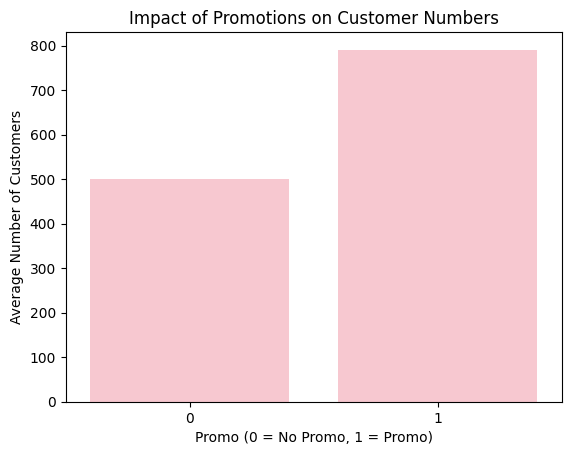

In [ ]:
# Step 2: Visualize the Impact of Promotions

sns.barplot(x=promo_customer_counts.index, y=promo_customer_counts.values,color='pink')
plt.title('Impact of Promotions on Customer Numbers')
plt.xlabel('Promo (0 = No Promo, 1 = Promo)')
plt.ylabel('Average Number of Customers')
plt.show()

Insight : customer strength depends on promotions if promo is active no.of customers 790.63 customers visited stores but without promo only 500.44 customer visited the store  

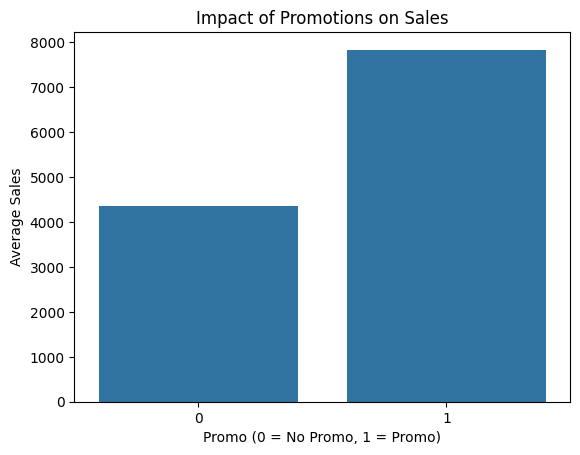

In [ ]:
# Assess Sales with and without Promotions

promo_sales = train_data.groupby('Promo')['Sales'].mean()

sns.barplot(x=promo_sales.index, y=promo_sales.values)
plt.title('Impact of Promotions on Sales')
plt.xlabel('Promo (0 = No Promo, 1 = Promo)')
plt.ylabel('Average Sales')
plt.show()


insigth: Sales also affected by promo when promo is active or on we can saw a higher sales because that time maximum customers visite our stores .

**Increased customer numbers during promotions indicate the success of promotional campaigns**

In [ ]:
train_data.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id,...,Rolling_Mean_6w,Rolling_Sum_6w,Year,Month,Day,WeekOfYear,IsHoliday,HolidayFlag,HolidayPeriod,Season
1016095,1,1,2013-01-01,0,0.0,0.0,0,a,1,0.0,...,0.0,0.0,2013,1,1,1,1,1,During Holiday,Regular
1014980,1,2,2013-01-02,5530,668.0,1.0,0,0,1,0.0,...,0.0,0.0,2013,1,2,1,0,0,Non-Holiday,Regular
1013865,1,3,2013-01-03,4327,578.0,1.0,0,0,1,0.0,...,0.0,0.0,2013,1,3,1,0,0,Non-Holiday,Regular
1012750,1,4,2013-01-04,4486,619.0,1.0,0,0,1,0.0,...,0.0,0.0,2013,1,4,1,0,0,Non-Holiday,Regular
1011635,1,5,2013-01-05,4997,635.0,1.0,0,0,1,0.0,...,0.0,0.0,2013,1,5,1,0,0,Non-Holiday,Regular


In [ ]:
#change sales dtype into int
train_data['Sales'] = train_data['Sales'].astype(int)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1017209 entries, 1016095 to 1114
Data columns (total 26 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   Store            1017209 non-null  int64         
 1   DayOfWeek        1017209 non-null  int32         
 2   Date             1017209 non-null  datetime64[ns]
 3   Sales            1017209 non-null  int64         
 4   Customers        1017209 non-null  float64       
 5   Open             1017209 non-null  float64       
 6   Promo            1017209 non-null  int64         
 7   StateHoliday     1017209 non-null  object        
 8   SchoolHoliday    1017209 non-null  int64         
 9   Id               1017209 non-null  float64       
 10  Lag_1            1017209 non-null  int64         
 11  Lag_2            1017209 non-null  int64         
 12  Lag_3            1017209 non-null  int64         
 13  Lag_4            1017209 non-null  int64         
 14  Lag_

In [ ]:
train_data = train_data.drop(columns=['Id'],axis=1)

In [ ]:
# Convert 'StateHoliday' column to string type before encoding
train_data['StateHoliday'] = train_data['StateHoliday'].astype(str)
test_data['StateHoliday'] = test_data['StateHoliday'].astype(str)

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train_data['StateHoliday'] = encoder.fit_transform(train_data['StateHoliday'])
test_data['StateHoliday'] = encoder.transform(test_data['StateHoliday'])

<Axes: >

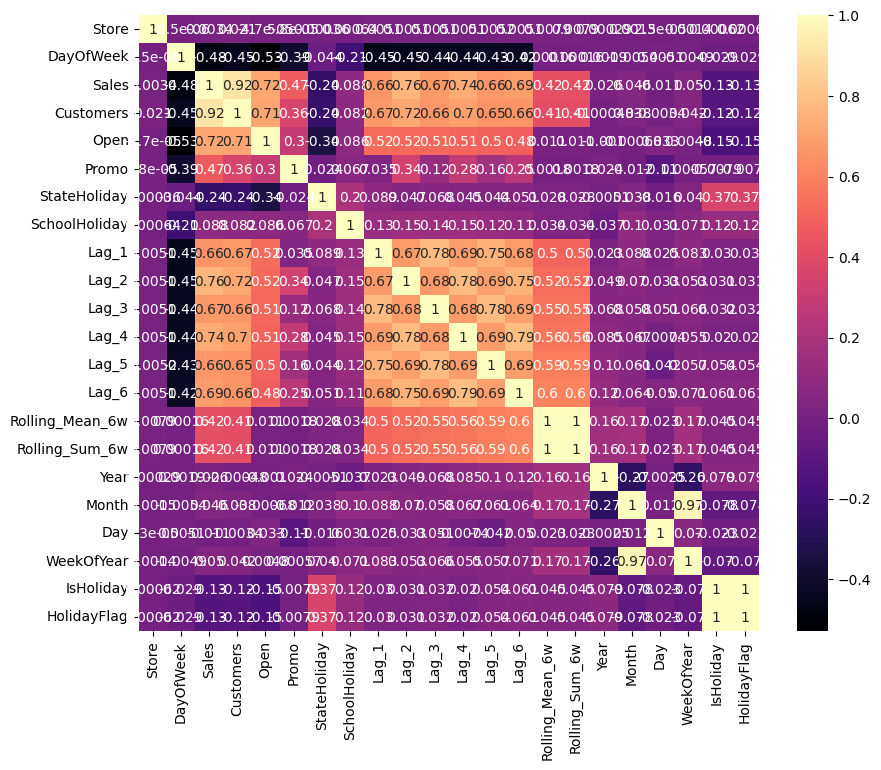

In [ ]:
# Select only numeric columns for correlation calculation
numeric_data = train_data.select_dtypes(include=np.number)

# Create the heatmap using the numeric data
plt.figure(figsize=(10,8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='magma')

Above heatmap showing positively related featuers like  store ,day of week ,custoers,open,promo,all lag featuers also.  

In [ ]:
# Now before model building i need to drop all extra featuers excluding test data featuers
train_data=train_data.drop(['HolidayFlag','Season','HolidayPeriod','Season'],axis=1)



In [ ]:
# again check shape
train_data.shape

(1017209, 22)

In [ ]:
train_data.isnull().sum()

,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0
Lag_1,0


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1017209 entries, 1016095 to 1114
Data columns (total 22 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   Store            1017209 non-null  int64         
 1   DayOfWeek        1017209 non-null  int32         
 2   Date             1017209 non-null  datetime64[ns]
 3   Sales            1017209 non-null  int64         
 4   Customers        1017209 non-null  float64       
 5   Open             1017209 non-null  float64       
 6   Promo            1017209 non-null  int64         
 7   StateHoliday     1017209 non-null  int64         
 8   SchoolHoliday    1017209 non-null  int64         
 9   Lag_1            1017209 non-null  int64         
 10  Lag_2            1017209 non-null  int64         
 11  Lag_3            1017209 non-null  int64         
 12  Lag_4            1017209 non-null  int64         
 13  Lag_5            1017209 non-null  int64         
 14  Lag_

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41088 entries, 40232 to 855
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Store            41088 non-null  int64         
 1   DayOfWeek        41088 non-null  int32         
 2   Date             41088 non-null  datetime64[ns]
 3   Sales            41088 non-null  int64         
 4   Customers        41088 non-null  float64       
 5   Open             41088 non-null  float64       
 6   Promo            41088 non-null  int64         
 7   StateHoliday     41088 non-null  int64         
 8   SchoolHoliday    41088 non-null  int64         
 9   Id               41088 non-null  float64       
 10  Lag_1            41088 non-null  int64         
 11  Lag_2            41088 non-null  int64         
 12  Lag_3            41088 non-null  int64         
 13  Lag_4            41088 non-null  int64         
 14  Lag_5            41088 non-null  int64   

In [ ]:
test_data = test_data.drop(columns=['Id'])# Id is non relavent featuer for  prediction .

In [ ]:
test_data.shape

(41088, 22)

In [ ]:
test_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 41088 entries, 40232 to 855
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Store            41088 non-null  int64         
 1   DayOfWeek        41088 non-null  int32         
 2   Date             41088 non-null  datetime64[ns]
 3   Sales            41088 non-null  int64         
 4   Customers        41088 non-null  float64       
 5   Open             41088 non-null  float64       
 6   Promo            41088 non-null  int64         
 7   StateHoliday     41088 non-null  int64         
 8   SchoolHoliday    41088 non-null  int64         
 9   Lag_1            41088 non-null  int64         
 10  Lag_2            41088 non-null  int64         
 11  Lag_3            41088 non-null  int64         
 12  Lag_4            41088 non-null  int64         
 13  Lag_5            41088 non-null  int64         
 14  Lag_6            41088 non-null  int64   

In [ ]:
# define features and target
X = train_data.drop(columns=['Sales'])
y = train_data['Sales']

In [ ]:
##X_train = train_data.drop(columns=['Sales','Date','Store']) # Drop the target and oyher non predicted

#y_train = train_data['Sales']

#X_tast = test_data.drop(columns=['Date','Sales','Store'])

In [ ]:
# Split data into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,shuffle=False)

In [ ]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline


# Import OneHotEncoder and other necessary modules
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
# or alternatively
from sklearn.preprocessing import *

# Define columns for scaling and encoding
numeric_features = ['SchoolHoliday','Customers','Open','Promo','Lag_1',
                    'Lag_2','IsHoliday','Lag_3','Lag_4','Lag_5','Lag_6','Rolling_Mean_6w','Rolling_Sum_6w','Month','Year','WeekOfYear'
                    ]
categorical_features = ['StateHoliday']  # Replace with actual column names

# Preprocessing steps for numeric and categorical data
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Apply transformations to the columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, None]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")


KeyboardInterrupt: 

note : hyperparameter tunning is skiped to keep crashed free session it takes to much time.

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['SchoolHoliday', 'Customers',
                                                   'Open', 'Promo', 'Lag_1',
                                                   'Lag_2', 'IsHoliday',
                                                   'Lag_3', 'Lag_4', 'Lag_5',
                                                   'Lag_6', 'Rolling_Mean_6w',
                                                   'Rolling_Sum_6w', 'Month',
                                                   'Year', 'WeekOfYear']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['StateHoliday'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [ ]:
# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)
# Calculate the metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
# Calculate RMSE manually for older versions if 'squared' is not supported
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))  # Calculate RMSE manually
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))    # Calculate RMSE manually

train_r2 = r2_score(y_train,y_train_pred)
test_r2 = r2_score(y_test,y_test_pred)

print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f'Train R2 :{train_r2 }')
print(f"Test R2 :{test_r2}")



Train MAE: 160.11146154349652
Test MAE: 447.5592034595195
Train RMSE: 252.22434453349013
Test RMSE: 671.2921551785586
Train R2 :0.9950679902965922
Test R2 :0.9658565627529909


# Sales prediction for six weeks ahead

In [ ]:
import pandas as pd

future_predictions = []
current_data = X_test.copy()  # Initialize with the preprocessed test data
current_data['Sales'] = 0  # Initialize 'Sales' column for rolling calculations

for i in range(6):  # Predict for 6 weeks
    # Prepare the feature vector for prediction
    # Use the last row of `current_data` for prediction (features must match those used during training)
    feature_vector = current_data.iloc[[-1]].drop(columns=['Sales'])

    # Predict sales for the next period
    next_prediction = pipeline.predict(feature_vector)[0]  # Use the pipeline for consistent preprocessing
    future_predictions.append(next_prediction)

    # Create a new row for the next period
    new_row = {'Sales': next_prediction}

    # Update lag features (e.g., Lag_1, Lag_2, etc.)
    for lag in [col for col in current_data.columns if col.startswith('Lag_')]:
        lag_value = current_data[lag].iloc[-1] if lag == 'Lag_1' else current_data[f'Lag_{int(lag.split("_")[1]) - 1}'].iloc[-1]
        new_row[lag] = lag_value

    # Update rolling features (e.g., Rolling_Mean_6w, Rolling_Sum_6w, etc.)
    rolling_window = 6  # Example for a 6-week rolling window
    for col in current_data.columns:
        if col.startswith('Rolling_Mean_') or col.startswith('Rolling_Sum_'):
            feature_name, window = col.split('_')[-2], int(col.split('_')[-1][:-1])
            if feature_name == 'Mean':
                new_row[col] = current_data['Sales'].iloc[-window:].mean()
            elif feature_name == 'Sum':
                new_row[col] = current_data['Sales'].iloc[-window:].sum()

    # Append the new row to `current_data`
    current_data = pd.concat([current_data, pd.DataFrame([new_row])], ignore_index=True)

# Convert future predictions into a DataFrame for visualization
future_predictions_df = pd.DataFrame({'Week': range(1, 7), 'Predicted_Sales': future_predictions})
print(future_predictions_df)


   Week  Predicted_Sales
0     1          7492.04
1     2          5896.91
2     3          5929.44
3     4          5881.92
4     5          5894.88
5     6          5902.01


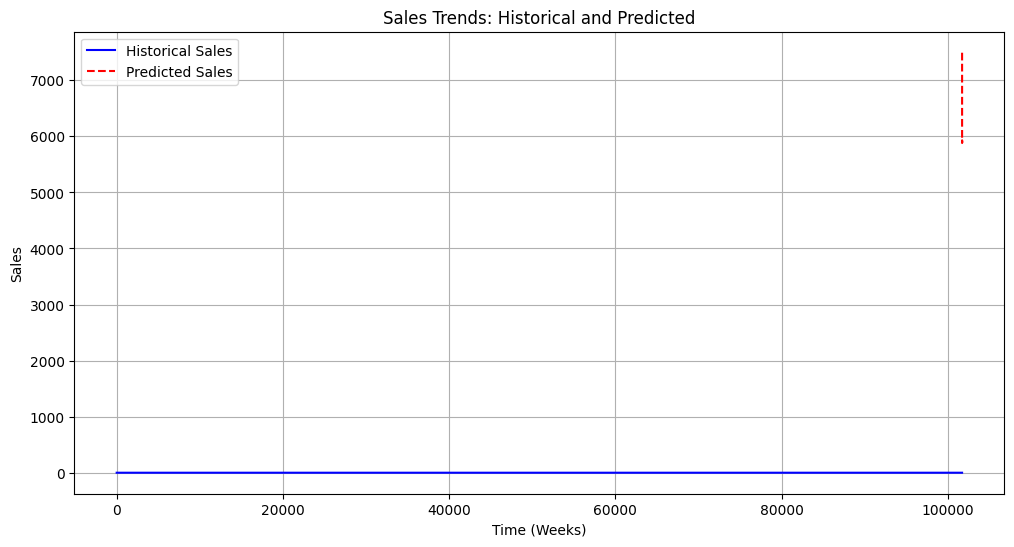

In [ ]:
import matplotlib.pyplot as plt

# Assuming `X_tast['Sales']` contains the historical sales data
# Combine old and predicted sales for visualization
historical_sales = current_data['Sales'][:len(X_test)]  # Old sales data
predicted_sales = future_predictions_df['Predicted_Sales']  # New predicted sales

# Extend the index for visualization
full_index = list(historical_sales.index) + list(range(len(historical_sales), len(historical_sales) + len(predicted_sales)))

# Combine historical and predicted sales into one series
combined_sales = pd.Series(list(historical_sales) + list(predicted_sales), index=full_index)

# Plot the data
plt.figure(figsize=(12, 6))

# Plot historical sales
plt.plot(historical_sales.index, historical_sales, label="Historical Sales", color="blue")

# Plot predicted sales
plt.plot(range(len(historical_sales), len(historical_sales) + len(predicted_sales)), predicted_sales, label="Predicted Sales", color="red", linestyle="--")

# Add titles and labels
plt.title("Sales Trends: Historical and Predicted")
plt.xlabel("Time (Weeks)")
plt.ylabel("Sales")
plt.legend()

# Show grid for better readability
plt.grid(True)

# Display the plot
plt.show()


In [ ]:

# Start with the last known data point
future_predictions = []
current_data = X_test.copy()  # Initialize with the preprocessed test data

for i in range(6):  # Predict for 6 weeks
    # Prepare features (lag and rolling features) for the next prediction
    # Instead of creating separate lag and rolling features, use the last row of current_data for prediction
    # Make sure the features match those used during training

    # Use all columns of the current_data for prediction to match the expected features
    feature_vector = current_data.iloc[[-1]]

    # Predict sales for the next period
    next_prediction = pipeline.predict(feature_vector)[0]  # Use the pipeline for consistent preprocessing
    future_predictions.append(next_prediction)

    # Update the dataset to include the prediction
    # Update current_data with the prediction, but consider relevant features for future predictions
    # In this case, simply add the prediction as a new row, preserving the structure of X_tast
    current_data = pd.concat([current_data, pd.DataFrame({'Sales': [next_prediction]})], ignore_index=True)

    # Update other relevant features (Lag_1, Rolling_Mean_6w, Rolling_Sum_6w, etc.) for the next prediction
    # Use appropriate logic to update these features based on the predicted sales
    current_data['Lag_1'].iloc[-1] = next_prediction  # Example: Update Lag_1
    # Similarly, update other lag features (Lag_2, Lag_3, etc.) and rolling features

# ... (Visualization part remains the same) ...

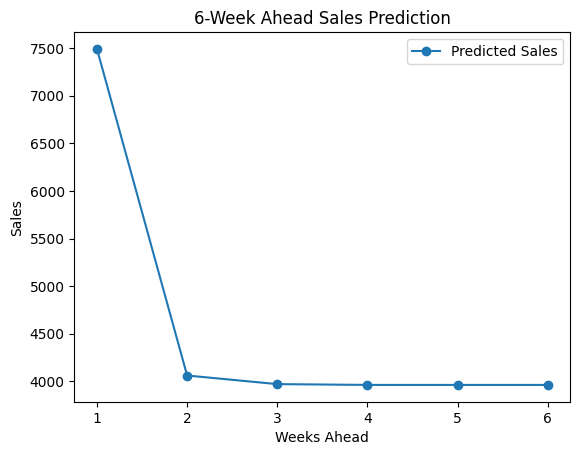

In [ ]:
import matplotlib.pyplot as plt

# Visualize predictions
weeks_ahead = range(1, 7)  # 6 weeks
plt.plot(weeks_ahead, future_predictions, marker='o', label='Predicted Sales')
plt.title('6-Week Ahead Sales Prediction')
plt.xlabel('Weeks Ahead')
plt.ylabel('Sales')
plt.legend()
plt.show()


# Featuer Importance

In [ ]:
# Get feature importances
importances = model.feature_importances_
features = X_train.columns  # Assuming X_train is a DataFrame with column names

# Get the feature names after the ColumnTransformer
features = pipeline.named_steps['preprocessor'].get_feature_names_out(input_features=X_train.columns)

# Create a DataFrame for better visualization
importances_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(importances_df)

                 Feature  Importance
1         num__Customers    0.805989
5             num__Lag_2    0.092162
8             num__Lag_4    0.019978
3             num__Promo    0.016078
7             num__Lag_3    0.011382
15       num__WeekOfYear    0.011284
12   num__Rolling_Sum_6w    0.009353
11  num__Rolling_Mean_6w    0.009290
4             num__Lag_1    0.007953
9             num__Lag_5    0.005825
10            num__Lag_6    0.005817
13            num__Month    0.002334
14             num__Year    0.001217
0     num__SchoolHoliday    0.000846
6         num__IsHoliday    0.000330
16   cat__StateHoliday_0    0.000101
17   cat__StateHoliday_1    0.000045
18   cat__StateHoliday_2    0.000013
19   cat__StateHoliday_3    0.000002
2              num__Open    0.000000


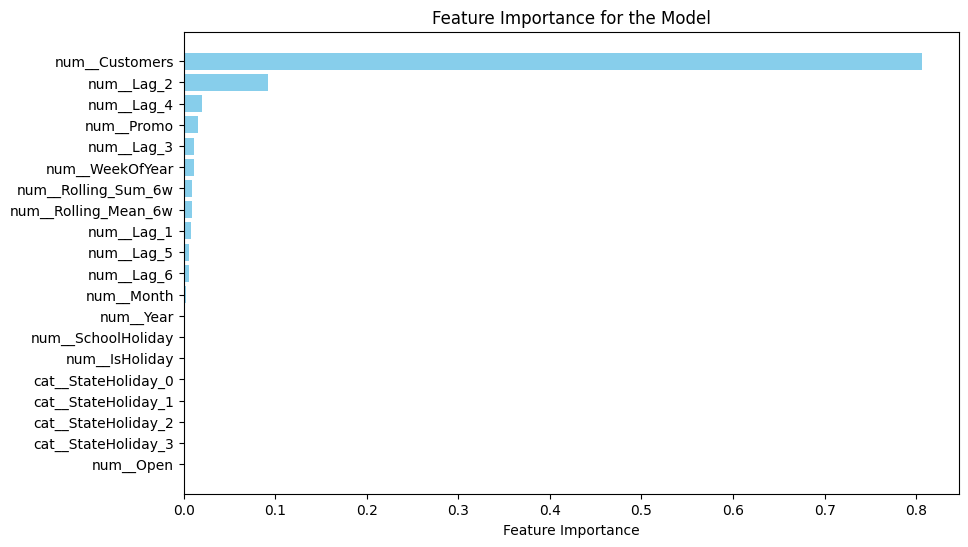

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance for the Model')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
import joblib
from datetime import datetime

# save the  model to local file system
joblib.dump(model,'Sales_predictions_model.pkl')


# load the model for later use

lodaed_model = joblib.load('Sales_predictions_model.pkl')

# Download the file to your local system
from google.colab import files
#files.download('Sales_predictions_model.pkl')


# Serializing the Model

In [ ]:

from joblib import dump
from datetime import datetime

# Generate a timestamp
timestamp = datetime.now().strftime('%d-%m-%Y-%H-%M-%S-%f')

# Save model with a timestamp
Sales_predictions = f'model-{timestamp}.joblib'
dump(model, Sales_predictions)

print(f'Model saved as {Sales_predictions}')



Model saved as model-31-12-2024-19-13-21-972057.joblib


# Use the Saved Models

When loading a model, specify the exact filename:


In [ ]:
from joblib import load
# Use the correct filename that was generated when you saved the model
# Replace 'model-10-08-2020-16-32-31-00.joblib' with the actual name of the saved model
# For example, if you saved the model using this code:
# Sales_predictions = f'model-{datetime.now().strftime("%d-%m-%Y-%H-%M-%S-%f")}.joblib'
# dump(model, Sales_predictions)
# Then you should use the correct filename when loading:
loaded_model = load('Sales_predictions_model.pkl')
# You can also check your file browser to see the names of the saved model files.

In [ ]:
import joblib
from sklearn.ensemble import RandomForestRegressor
import logging
import pandas as pd

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='model_joblib.log',
    filemode='w'
)
logger = logging.getLogger()

# Define model path
model_path = '/content/model-31-12-2024-19-13-21-972057.joblib'

def train_and_save_model(X_train, y_train, model_path):
    try:
        logger.info("Starting model training...")

        # ----> Extract numerical features from 'Date' column <----
        X_train['Date'] = pd.to_datetime(X_train['Date'])  # Convert to datetime if not already
        X_train['Year'] = X_train['Date'].dt.year
        X_train['Month'] = X_train['Date'].dt.month
        X_train['Day'] = X_train['Date'].dt.day
        # Add more features like WeekOfYear, DayOfWeek, etc., if needed

        # Drop the original 'Date' column
        X_train = X_train.drop(columns=['Date'])

        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)
        logger.info("Model training completed.")

        # Save the model using joblib
        joblib.dump(model, model_path)
        logger.info(f"Model saved successfully at {model_path}")

        return model
    except Exception as e:
        logger.error(f"Error during training: {e}")
        raise

def load_and_predict(model_path, X_test):
    try:
        logger.info(f"Loading model from {model_path}...")
        model = joblib.load(model_path)
        logger.info("Model loaded successfully.")

        # ----> Extract numerical features from 'Date' column <----
        X_test['Date'] = pd.to_datetime(X_test['Date'])  # Convert to datetime if not already
        X_test['Year'] = X_test['Date'].dt.year
        X_test['Month'] = X_test['Date'].dt.month
        X_test['Day'] = X_test['Date'].dt.day
        # Add more features like WeekOfYear, DayOfWeek, etc., if needed

        # Drop the original 'Date' column
        X_test = X_test.drop(columns=['Date'])

        # Make predictions
        logger.info("Starting predictions...")
        predictions = model.predict(X_test)
        logger.info("Predictions completed.")
        return predictions
    except Exception as e:
        logger.error(f"Error during prediction: {e}")
        raise

# Train and save the model
model = train_and_save_model(X_train, y_train, model_path)

# Load and make predictions
predictions = load_and_predict(model_path, X_test)
logger.info(f"Predictions: {predictions}")

NameError: name 'X_train' is not defined

Model Deployment

In [ ]:
! pip install flask

In [ ]:
from flask import Flask, request, jsonify
import joblib
import numpy as np
import pandas as pd

# Initialize Flask app
app = Flask(__name__)

# Load the saved model (make sure to provide the correct path to your model)
model_path = '/content/model-31-12-2024-19-13-21-972057.joblib'  # Update this path
model = joblib.load(model_path)

@app.route('/')
def home():
    return "Sales Prediction Model API is running!"

# Prediction endpoint
@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get data from the POST request (expecting JSON)
        data = request.get_json(force=True)

        # Assuming the input features are in a list called 'features'
        input_data = pd.DataFrame([data]) # Create DataFrame from input

        # Preprocess the input data (extract date features)
        input_data['Date'] = pd.to_datetime(input_data['Date'])
        input_data['Year'] = input_data['Date'].dt.year
        input_data['Month'] = input_data['Date'].dt.month
        input_data['Day'] = input_data['Date'].dt.day
        # Add other date-related features if needed

        # Drop the original 'Date' column
        input_data = input_data.drop(columns=['Date'])

        # Get predictions from the model
        prediction = model.predict(input_data)

        # Return the prediction as a JSON response
        return jsonify({'prediction': prediction.tolist()})

    except Exception as e:
        return jsonify({'error': str(e)}), 400

if __name__ == '__main__':
    app.run(debug=True, port=5000)  # Run on port 5000

Running Flask in Colab:

In [ ]:
!pip install pyngrok


Use ngrok to Expose the Flask App:

In [ ]:
from pyngrok import ngrok

# Set up a tunnel to the Flask app (run it on port 5000)
sales = ngrok.connect(5000 )
print(f"Flask app is running at {public_url}")


Run Flask App: Finally, run the Flask app in the same notebook:

In [ ]:
app.run(port=5000)  # start flask app
